# Decision Tree Classifier for 30-day Hospital Readmission Prediction using MIMIC-III Database

__Alexis Barrett__

_Advisors: Ron Mahabir & Olga Gkountouna_


## 1. Introduction

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The Centers for Medicare & Medicaid Services (CMS) consider hospital readmission within 30 days preventable and readmission has become a common measure for quality of care.  In 2012, CMS changed Medicare payout so that hospitals can profit during a patient’s first admission but do not receive any reimbursement for a patient readmission (HRRP, 2019). Similar penalties have been implemented in other countries. At the same time, Meaningful Use required use of electronic health records with a clinical decision support system, or CDSS, in all healthcare facilities (2019). 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Since all clinical data is now digitized, the path is clear for data scientists to build predictive algorithms that can be implemented in clinical settings, however, according to Jiang, Chin, Qu, and Tsiu, most computational algorithms have underperformed (2018). Use of underperforming models could put patients at health risk or encourage unnecessary procedures, so models should be optimized for reliability. Understanding the factors that predict hospital readmission is incredibly valuable to physicians and hospital administrators, as readmission is detrimental to patients and costly to hospitals. This research aims to discover the limitations of predictive models for the 30-day hospital readmission problem.


## 2. Methods

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.1. Data

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;In the task of predicting and preventing hospital readmission within 30 days, the most meaningful results come from data which is the same or similar to patient data as collected in hospitals. The ideal data would come directly from healthcare industry eletronic health records. However, HIPAA compliance restricts access to patient health data to healthcare professionals. The MIMIC-III (Medical Information Mart for Intensive Care III) database was curated by a team from Masaachusettes Instistute of Technology to accommodate data scientists and other researchers (Johnson, 2016). The MIMIC-III  database is a relational database of healthcare data merged from two electronic health record systems used by the intensive care unit at Beth Israel Deaconess Medical Center in Boston, MA. The data was collected from real patients during hospital visits by physicians and nurses and other clinical staff. The data has been masked to protect patient privacy and maintain HIPAA regulations. Personally identifiable information (PII) and protected health information (PHI) were removed from the dataset, including names, geographic identifiers, social security numbers. Medical record numbers, account numbers, and dates of service were changed. The database is available free for researchers after an application and compliance process. 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;MIMIC-III has over 56,000 hospital admissions, of 40,000 patients. Of these, 23,000 hospital stays included admisison to the intensive care unit. Patients, admissions, and ICU admissions are each single tables in MIMIC-III. An additional 23 tables comprise the clinical data for each patient hospital stay. The set of tables were downloaded individually as text files to be uploaded into the local servers. The DB schema was made available on the MIMIC-III resource site. Certain tables were not loaded as they were deemed unnecessary and beyond the scope of this project. The primary linking features between tables were Subject ID, Admission ID, ICU Stay ID, with supporting tables for diagnoses, procedures, orders, inputs and outputs, and items, a collective table including clinical information such as orders, lab results, and imaging (Johnson, 2016).  

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.4. Data Cleaning in Python

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Data cleaning techniques and procedures were continued using Python in the Jupyter Lab environment. The primary tool used for data manipulation and cleaning was the Pandas package. Pandas is a Python Library created specifically for data analysis. It is an extension of the NumPy library, but made specific to disparate datatypes. The library includes many functions available in R statistical modeling environment. 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Many features to be included in the readmission model were not available directly from the original database and thus would be calculated within the Pandas DateFrame object.  

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;A set of functions were written to encode categorical data including gender, marital status, insurance, type of admission and type of discharge. Encoding is an important data processing step as categorical data cannot be fit in a machine learning model. Features of many categories were made to be individual columns as binary variables for each value in the dataset, using a manual version of the One-Hot encoding technique.  However, since most machine learning algorithms only function using numeric data, for translational ease, encoding techniques were applied at this stage. 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Several admissions were exluded from the dataset at this stage, on the basis of the type of discharge. It was determined that readmission data would not be valid from discharges which took place against medical advice, discharges due to patient death, and discharges which were transfers to other hospitals. 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Additional functions were written to calculate age at admission and  length of stay. Age is defined as years, expressed as a decimal, between admission date-time and date of birth. Length of stay is the number of days, expressed as a decimal, between admission date-time and discharge date-time. 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Statistical normalization techniques were considered to prevent overemphasizing of features with high numeric values as compared to features with low numeric values. By equalizing the scales, equal importance could be placed upon age, length of stay, and binary categorical values. In contrast to encoding techniques, it was determined that normalization would not be a required processing stage, given the ability of the Decision Tree Classifier to find a split point in the distribution of each variable based on the presence or absence of the target variable.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Clinical data was included in the dataset on the basis of medical coding systems, ICD-9, CPT-4, and Diagnosis Related Groups (DRGs). Cohort inclusion status was derived from diagnosis data for the following high risk cohorts: Acute Myocardial Infarction, Congestive Heart Failure, Pneumonia, Chronic Obstructive Pulmonary Disease, and Total Hip and/or Knee Arthroplasty. Inclusion status for each ICD-9 diagnosis category, number of diagnoses and number of procedures during the hospital stay were also derived from coding systems. DRG values were observed but not included, however the Severity of Illness ratings within DRG systems were included in the dataset.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The final function was built to identify target values in the dataset. A target value was defined as a hospital admission which preceeded a second hospital admission within 30 days of the prior discharge. Values in the dataset with that quality were labeled with a 1 and all other values labeled 0. 

In [10]:
import pandas as pd
import numpy as np
import datetime

In [11]:
ptsdf = pd.read_csv('/Users/alexisbarrett/492/mimic/Postgres/PATIENTS.csv',
                    parse_dates=[3,4,5],infer_datetime_format=True)
admdf = pd.read_csv('/Users/alexisbarrett/492/mimic/Postgres/ADMISSIONS.csv',
                    parse_dates=[3,4],infer_datetime_format=True)

In [12]:
admdf2 = admdf[['SUBJECT_ID', 'HADM_ID', 'ADMITTIME']]
admdf2 = admdf2.sort_values(by=['SUBJECT_ID', 'ADMITTIME'])
prev = [0]*len(admdf2)
for i in range(len(admdf2)-1,1,-1):
    a = 1
    sub1 = admdf2.loc[i, 'SUBJECT_ID']
    sub2 = admdf2.loc[i-a, 'SUBJECT_ID']
    while sub1 == sub2:
        s1adm = admdf2.loc[i, 'ADMITTIME']
        s2adm = admdf2.loc[i-a, 'ADMITTIME']
        if (s1adm-s2adm).total_seconds() < 31536000:
            prev[i]+=1
        a+=1
        sub2 = admdf2.loc[i-a, 'SUBJECT_ID']
admdf['prevadms'] = pd.Series(prev)


In [13]:
df1 = pd.merge(admdf, ptsdf, on='SUBJECT_ID')

demdf = df1[['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME', 
                   'ADMISSION_TYPE', 'DISCHARGE_LOCATION', 
                   'INSURANCE', 'MARITAL_STATUS', 'GENDER','DOB', 'prevadms']]

In [14]:
def age(row):
    age = row['ADMITTIME'] - row['DOB']
    secondsold = age.total_seconds()
    secondsperyear = 31536000
    age = secondsold/secondsperyear
    
    if age > 90:
        age = 90
        
    return age/90

demdf['age'] = demdf.apply(age, axis=1)

def los(row): 
    los = row['DISCHTIME'] - row['ADMITTIME']
    
    secondsstayed = los.total_seconds()
    secondsperday = 86400
    daysstayed = secondsstayed/secondsperday

    return daysstayed/365

demdf['LOS'] = demdf.apply(los, axis = 1)

def female(row): 
    if row['GENDER'] == 'F':
        return 1
    else:
        return 0

demdf['female'] = demdf.apply(female, axis=1)

def emergency(row):
    if row['ADMISSION_TYPE'] == 'EMERGENCY':
        return 1
    else:
        return 0
    
demdf['emergency'] = demdf.apply(emergency, axis = 1)

def medicare(row):
    if row['INSURANCE'] == ('Medicare' or 'Medicaid' or 'Government'):
        return 1
    else:
        return 0

demdf['medicare'] = demdf.apply(medicare, axis=1)


def married(row):
    if row['MARITAL_STATUS'] == ('MARRIED' or 'LIFE PARTNER'):
        return 1
    else:
        return 0
    
demdf['married'] = demdf.apply(married,axis = 1)

def unmarried(row):
    
    if row['MARITAL_STATUS'] == ('DIVORCED' or 'WIDOWED' or 'SEPARATED'):
        return 1
    else:
        return 0
    
demdf['unmarried'] = demdf.apply(unmarried,axis = 1)

def single(row):
    
    if row['MARITAL_STATUS'] == ('SINGLE'):
        return 1
    else:
        return 0
    
demdf['single'] = demdf.apply(single,axis = 1)


def include(row):
    
    if row['DISCHARGE_LOCATION']!=('DISC-TRAN CANCER/CHLDRN H' or 'DEAD/EXPIRED' or 'REHAB/DISTINCT PART HOSP' or
       'LONG TERM CARE HOSPITAL' or 'DISC-TRAN TO FEDERAL HC' or 
       'SHORT TERM HOSPITAL' or 'HOSPICE-MEDICAL FACILITY' or 'HOSPICE-HOME' or
       'LEFT AGAINST MEDICAL ADVI' or 'DISCH-TRAN TO PSYCH HOSP'):
        return 1
    else:
        return 0 
    
demdf['include'] = admdf.apply(include, axis = 1)

df3 = demdf.loc[demdf['include']==1]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata

In [15]:
df4 = df3[['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME', 'prevadms', 'age', 'LOS', 'female', 'emergency', 'medicare', 'married', 'unmarried',
       'single']]

In [16]:
pdf = pd.read_csv('/Users/alexisbarrett/492/mimic/Postgres/PROCEDURES_ICD.csv')
pctdf = pdf[['HADM_ID', 'SEQ_NUM']]
pctdf = pctdf.groupby(['HADM_ID'], as_index=False).max()
pctdf.columns = ['HADM_ID', 'proc_ct']

In [17]:
dxdf = pd.read_csv('/Users/alexisbarrett/492/mimic/Postgres/DIAGNOSES_ICD.csv')
dxctdf = dxdf[['HADM_ID', 'SEQ_NUM']]
dxctdf = dxctdf.groupby(['HADM_ID'], as_index=False).max()
dxctdf.columns = ['HADM_ID', 'dx_ct']

In [18]:
df5 = pd.merge(df4,pctdf,on='HADM_ID')
df6 = pd.merge(df5,dxctdf,on='HADM_ID')

In [19]:
dxdf = pd.read_csv('/Users/alexisbarrett/492/mimic/Postgres/DIAGNOSES_ICD.csv')
dxdf = dxdf.loc[dxdf['SEQ_NUM']==1]





#Currently only using primary diagnosis for the first visit. We could look at all diagnoses related to that visit or a larger sample, 5
#Need to check diagnosis for second visit and compare. 

In [20]:
def ami(row):
    if row['ICD9_CODE']== ('41000' or '41001'or '41010'or '41011'or '41020'or '41021'or 
       '41030'or '41031'or '41040'or '41041'or '41050'or '41051'or 
       '41060'or '41061'or '41070'or '41071'or '41080'or '41081'or 
        '41090' or '41091'):
        return 1
    else:
        return 0
dxdf['AMI'] = dxdf.apply(ami, axis = 1)

def chf(row):
    if row['ICD9_CODE']==('40201'or '40211'or '40291'or '40401'or '40403'or '40411'or 
       '40413'or '40491'or '40493'or '4280'or  '4281'or 
       '42820'or '42821'or '42822'or '42823'or
        '42830'or '42831'or '42832'or '42833'or
        '42840'or '42841'or '42842'or '42843'or '4289'):
        return 1
    else:
        return 0
dxdf['CHF'] = dxdf.apply(chf, axis = 1)

def pn(row):
    if row['ICD9_CODE']==('4800'or  '4801'or  '4802'or  '4803'or  '4808'or  '4809'or 
      '481'or   '4820'or  '4821'or  '4822'or  '48230'or '48231'or 
      '48232'or '48239'or '48240'or '48241'or '48249'or '48281'or 
        '48282'or '48283'or '48284'or '48289'or '4829'or  '4830'or 
        '4831'or  '4838'or  '485'or   '486'or   '4870'or  '48242'or '48811'):
        return 1
    else:
        return 0
dxdf['PN'] = dxdf.apply(pn, axis = 1)

def copd(row):
    if row['ICD9_CODE']==('49121'or '49122'or '4918'or '4919'or  '4928'or  '49320'or 
        '
                          49321'or '49322'or '496'or  '51881'or '51882'or '51884'or
        '7991'):
        return 1
    else:
        return 0
dxdf['COPD'] = dxdf.apply(copd, axis = 1)

def thka(row):
    if row['ICD9_CODE']==('V4364'or 'V4365'):
        return 1
    else:
        return 0
dxdf['THA_TKA'] = dxdf.apply(thka, axis = 1)

def dxc1(row):
    dx = row['ICD9_CODE']
    if dx[0] == 'V':
        return 0
    elif dx[0] == 'E':
        return 0
    elif float(dx[0:3])<140:
        return 1
    else:
        return 0
dxdf['c1'] = dxdf.apply(dxc1, axis=1)

def dxc2(row):
    dx = row['ICD9_CODE']
    if dx[0] == 'V':
        return 0
    elif dx[0] == 'E':
        return 0
    elif 140 <= float(dx[0:3]) < 240:
        return 1
    else:
        return 0
dxdf['c2'] = dxdf.apply(dxc2, axis=1)

def dxc3(row):
    dx = row['ICD9_CODE']
    if dx[0] == 'V':
        return 0
    elif dx[0] == 'E':
        return 0
    elif 240 <= float(dx[0:3]) < 280:
        return 1
    else:
        return 0
dxdf['c3'] = dxdf.apply(dxc3, axis=1)

def dxc4(row):
    dx = row['ICD9_CODE']
    if dx[0] == 'V':
        return 0
    elif dx[0] == 'E':
        return 0
    elif 280 <= float(dx[0:3]) < 290:
        return 1
    else:
        return 0
dxdf['c4'] = dxdf.apply(dxc4, axis=1)

def dxc5(row):
    dx = row['ICD9_CODE']
    if dx[0] == 'V':
        return 0
    elif dx[0] == 'E':
        return 0
    elif 290 <= float(dx[0:3]) < 320:
        return 1
    else:
        return 0
dxdf['c5'] = dxdf.apply(dxc5, axis=1)

def dxc6(row):
    dx = row['ICD9_CODE']
    if dx[0] == 'V':
        return 0
    elif dx[0] == 'E':
        return 0
    elif 320 <= float(dx[0:3]) < 390:
        return 1
    else:
        return 0
dxdf['c6'] = dxdf.apply(dxc6, axis=1)

def dxc7(row):
    dx = row['ICD9_CODE']
    if dx[0] == 'V':
        return 0
    elif dx[0] == 'E':
        return 0
    elif 390 <= float(dx[0:3]) < 460:
        return 1
    else:
        return 0
dxdf['c7'] = dxdf.apply(dxc7, axis=1)

def dxc8(row):
    dx = row['ICD9_CODE']
    if dx[0] == 'V':
        return 0
    elif dx[0] == 'E':
        return 0
    elif 460 <= float(dx[0:3]) < 520:
        return 1
    else:
        return 0
dxdf['c8_resp_system'] = dxdf.apply(dxc8, axis=1)

def dxc9(row):
    dx = row['ICD9_CODE']
    if dx[0] == 'V':
        return 0
    elif dx[0] == 'E':
        return 0
    elif 520 <= float(dx[0:3]) < 580:
        return 1
    else:
        return 0
dxdf['c9'] = dxdf.apply(dxc9, axis=1)

def dxc10(row):
    dx = row['ICD9_CODE']
    if dx[0] == 'V':
        return 0
    elif dx[0] == 'E':
        return 0
    elif 580 <= float(dx[0:3]) < 630:
        return 1
    else:
        return 0
dxdf['c10'] = dxdf.apply(dxc10, axis=1)

def dxc11(row):
    dx = row['ICD9_CODE']
    if dx[0] == 'V':
        return 0
    elif dx[0] == 'E':
        return 0
    elif 630 <= float(dx[0:3]) < 680:
        return 1
    else:
        return 0
dxdf['c11'] = dxdf.apply(dxc11, axis=1)

def dxc12(row):
    dx = row['ICD9_CODE']
    if dx[0] == 'V':
        return 0
    elif dx[0] == 'E':
        return 0
    elif 680 <= float(dx[0:3]) < 710:
        return 1
    else:
        return 0
dxdf['c12'] = dxdf.apply(dxc12, axis=1)

def dxc13(row):
    dx = row['ICD9_CODE']
    if dx[0] == 'V':
        return 0
    elif dx[0] == 'E':
        return 0
    elif 710 <= float(dx[0:3]) < 740:
        return 1
    else:
        return 0
dxdf['c13'] = dxdf.apply(dxc13, axis=1)

def dxc14(row):
    dx = row['ICD9_CODE']
    if dx[0] == 'V':
        return 0
    elif dx[0] == 'E':
        return 0
    elif 740 <= float(dx[0:3]) < 760:
        return 1
    else:
        return 0
dxdf['c14'] = dxdf.apply(dxc14, axis=1)

def dxc15(row):
    dx = row['ICD9_CODE']
    if dx[0] == 'V':
        return 0
    elif dx[0] == 'E':
        return 0
    elif 760 <= float(dx[0:3]) < 780:
        return 1
    else:
        return 0
dxdf['c15'] = dxdf.apply(dxc15, axis=1)

def dxc16(row):
    dx = row['ICD9_CODE']
    if dx[0] == 'V':
        return 0
    elif dx[0] == 'E':
        return 0
    elif 780 <= float(dx[0:3]) < 800:
        return 1
    else:
        return 0
dxdf['c16'] = dxdf.apply(dxc16, axis=1)

def dxc17(row):
    dx = row['ICD9_CODE']
    if dx[0] == 'V':
        return 0
    elif dx[0] == 'E':
        return 0
    elif 800 <= float(dx[0:3]) < 999:
        return 1
    else:
        return 0
dxdf['c17_injury_poisoning'] = dxdf.apply(dxc17, axis=1)

In [21]:
dxdf = dxdf[['HADM_ID', 'AMI', 'CHF',
       'PN', 'COPD', 'THA_TKA', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8_resp_system',
       'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17_injury_poisoning']]

In [22]:
df7 = pd.merge(df6, dxdf, on='HADM_ID')

In [23]:
drgdf = pd.read_csv('/Users/alexisbarrett/492/mimic/Postgres/DRGCODES.csv')
drgdf = drgdf[['HADM_ID', 'DRG_SEVERITY']]
drgdf = drgdf.groupby(['HADM_ID'],as_index=False).max()
drgdf.columns = ['HADM_ID', 'soi']
drgdf = drgdf.fillna(0)

In [24]:
df8 = pd.merge(df7,drgdf, on='HADM_ID')

In [25]:
def Target1(df):
    df2 = df.sort_values(by=['SUBJECT_ID', 'ADMITTIME'])
    tar = [0]*len(df)
    for i in range(len(df)-1):
        record1subject = df.loc[i, 'SUBJECT_ID']
        record2subject = df.loc[i+1, 'SUBJECT_ID']
        if record1subject == record2subject:
            disch = df.loc[i,'DISCHTIME']
            nextadmit = df.loc[i+1, 'ADMITTIME']
            dischargeddt = nextadmit - disch
            secondsdischarged = dischargeddt.total_seconds()
            secondsperday = 86400
            daysdischarged = secondsdischarged/secondsperday
            
            #Add conditional for the diagnosis category being the same for both admissions -- different category 
            #won't be due to the same cause, and a <30 day readmission wouldn't be a valid datapoint
            
            if daysdischarged < 30:
                tar[i] = 1
        else:
            continue
    df2['target1'] = pd.Series(tar)
    return df2

df9 = Target1(df8)

In [ ]:
#consider that we only need N-1 variables for N categories.. so c17, for example, may not need a column.

In [26]:
df10 = df9[['prevadms','age', 'LOS',
       'female', 'emergency', 'medicare', 'married', 'unmarried', 'single', 'proc_ct', 'dx_ct',
       'AMI', 'CHF', 'PN', 'COPD', 'THA_TKA', 'c1', 'c2', 'c3', 'c4', 'c5',
       'c6', 'c7', 'c8_resp_system', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16',
       'c17_injury_poisoning', 'soi', 'target1']]

In [27]:
df10.to_csv('clean1212.csv')

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2.5. Feature Selection with Clustering

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The feature selection process described above was a repeated and refined process based on unsupervised clustering of the data. Though supervised learning makes it possible to discover and build a predictive model, clustering techniques are indispensible for feature selection. The MIMIC-III dataset has an extensive number of potential features to describe each encounter, and the challenge presented for data scientists is to determine the features which represent important qualties of real world scenarios. Overspecified datasets are unable to be learned at all, so a greater number of features requires an exponential number of records if the dataset is to be learned sufficiently. Additionally, the effectiveness of distance functions and entropy calculations become ineffective with too many variables and overfitting becomes unavoidable. 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The K-Means clustering algorithm was chosen to explore and evaluate the importance of various test features in the final dataset to accommodate for these potential issues with dimensionality. For a wide range of combinations, the clustering technique was applied to discover combinations of features with the ability to partition the dataset between hospital stays leading to readmission and non-readmission hospital stays. As the multidimensional clusters cannot be visualized, a simple statistical measure sufficied to determine if a particular cluster maintained the pre-existing proportions of positive and negative target records. Feature selections with only the highest discriminatory ability were chosen to remain in the finalized dataset.  

In [28]:
from sklearn.cluster import KMeans
#cs = 2 
inertias = []
#try different values and compare the proportions of the output.

for cs in range(2,10):
    km = KMeans(n_clusters = cs)

    labels = km.fit_predict(X[:,0:2])
    totalcts = np.zeros(cs)
    for i in range(len(X)):
        totalcts[labels[i]] += 1
    print(totalcts)
    inertias.append(km.inertia_)
    

print(inertias)
#consider creating a visual for this.

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.6. Modeling

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Several libraries were used in fitting and testing the model for 30-day hospital readmission. Pandas and NumPy were again used for data handling within the Python environment.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The popular Scikit-Learn library of machine learning in Python was the primary package used. The decision tree classifier was chosen as the algorithm to fit this data for a number of reasons. First, at its core, the problem is a supervised binary classification problem and the dataset was split into two groups. The positive class label being an admission which led to a readmission within 30 days, and the negative class label being an admission which did not lead to a readmission within 30 days. The Decision Tree classifier is a transparent and interpretable supervised classifier, unlike many of its competing algorithms, such as random forest and gradient boosted trees, which, though generally having higher accuracy, do not disclose the way in which the model learns. Observation of the various decision nodes would be necessary to find greater insight into the dynamics at play leading up to a readmission event. Readmission is a skewed phenomena with only 6% of all hospital stays leading to a readmission in the MIMIC-III database. Skewed datasets require particular attention to the target variable. The Decision Tree classifier included parameters to add class weight to the admission records with readmission so that greater importance was placed on identifying these records accurately. 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The dataset would be split into training and testing subsamples, thereby allowing separation of the data on which the model is trained and tested. This avoids overfitting and proves that the model is learning the patterns in the dataset, rather than the dataset itself. Additionally, K-fold Cross validation techniques were used. Cross validation is important because it measures the reproducibility of the model across variable training and testing data. In this way the data is split K times (in this case 3 times), and each of the K sections will serve once as the as the testing dataset and K-1 times as a segment of the training data. As this is an imbalanced class problem, the dataset was also stratified, ensuring that each of the K segments maintained equal proportions of positive and negative targets, as a model trained on a disproportionate dataset of only 1% readmissions would not be able to account for and accurately predict readmissions in an equally disproportionate dataset of 10% readmissions. 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;As training classifiers can be computationally heavy, the pickling tool in Python was used to save and reload trained classifier objects as necessary. In particular, pickled classifiers needed to be reapproached when evaluating and comparing various interations of a model. Models were evaluated using Scikit-Learn's functions for accuracy score, confusion matrices, ROC curve, AUC curve, and generalized classification report. Models were visualized using several techniques. Both GraphViz and dtreeviz libraries were used for visualizing nodes and leaves of the trees. The GraphViz trees were best fit for repeated manual interpretation, and dTreeViz for sharing of results. Seaborn was used to visualize confusion matrices with the heatmap function, for communicating similarities and differences of models. 

In [29]:
import pandas as pd
import numpy as np


#sampling
from imblearn.over_sampling import SMOTE


#validation
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold



#model
from sklearn.tree import DecisionTreeClassifier 

#evaluate
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, classification_report

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Once specific approaches were chosen, the cleaned data was reloaded as a new Pandas DataFrame, and the column labels were used to split the data into separate input and target sets. These tables were converted into NumPy arrays for input into the machine learning classifier.

In [30]:
#load clean dataset
df = pd.read_csv('clean1212.csv') 

In [31]:
#define input-target sets
X = np.array(df[['prevadms', 'age', 'LOS', 'female', 'emergency', 'medicare',
       'married', 'unmarried', 'single', 'proc_ct', 'dx_ct', 'AMI', 'CHF', 'PN', 'COPD', 'THA_TKA',
       'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8_resp_system', 'c9', 'c10', 'c11',
       'c12', 'c13', 'c14', 'c15', 'c16', 'c17_injury_poisoning', 'soi']] )
y = np.array(df['target1'])
features = ['prevadms', 'age', 'LOS', 'female', 'emergency', 'medicare',
       'married', 'unmarried', 'single', 'proc_ct', 'dx_ct', 'AMI', 'CHF', 'PN', 'COPD', 'THA_TKA',
       'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8_resp_system', 'c9', 'c10', 'c11',
       'c12', 'c13', 'c14', 'c15', 'c16', 'c17_injury_poisoning','soi']

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The following functions served to define the specifications of the Decision Tree classifier. The loss function chosen was Entropy, as opposed to the alternative, the Gini loss function. The levels of the decision tree were tested at various depths, accounting for overfitting at high depths and poor partitioning of data at shallow depths. The final depth chosed was five. The class weight for the readmission target variable was tested and adjusted to maximize accuracy and minimize weight, and found to be that a 1:10 ratio was the most effective weight distribution. 

In [32]:
clf = DecisionTreeClassifier(criterion = "entropy", 
                             random_state = 100, 
                             min_samples_leaf = 5, 
                             max_depth = 8,
                             class_weight = {0:1, 1:14}) 


kf = StratifiedKFold(n_splits = 5)

cmlst = []
reportlst = []
impfeatlst = []
rocs = []

for train, test in kf.split(X, y):
    X_train = X[train]
    X_test = X[test]
    y_train = y[train]
    y_test = y[test]
    
    sm = SMOTE(sampling_strategy = 0.1, k_neighbors = 5)
    X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
    
    clf.fit(X_train_res, y_train_res) 
    y_pred = clf.predict(X_test) 
    
    cmlst.append(confusion_matrix(y_test, y_pred))
    reportlst.append(classification_report(y_test,y_pred))
    
    feature_imports = clf.feature_importances_
    most_imp_features = pd.DataFrame([f for f in zip(features, feature_imports)],
                                 columns=["Feature", "Importance"]).nlargest(10, "Importance")
    impfeatlst.append(most_imp_features)
    
    rocs.append(roc_curve(y_test,y_pred))

In [33]:
from sklearn.tree import DecisionTreeRegressor

y = np.array(df['target2'])

reg = DecisionTreeRegressor(random_state=0,
                           min_samples_leaf = 5, 
                             max_depth = 8)

kf2 = KFold(n_splits = 5)

cmlst = []
reportlst = []
impfeatlst = []
rocs = []

for train, test in kf2.split(X, y):
    X_train = X[train]
    X_test = X[test]
    y_train = y[train]
    y_test = y[test]
    
    #sm = SMOTE(sampling_strategy = 0.1, k_neighbors = 5)
    #X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
    
    reg.fit(X_train, y_train) 
    y_pred = clf.predict(X_test) 
    
    #cmlst.append(confusion_matrix(y_test, y_pred))
    #reportlst.append(classification_report(y_test,y_pred))
    
    feature_imports = reg.feature_importances_
    most_imp_features = pd.DataFrame([f for f in zip(features, feature_imports)],
                                 columns=["Feature", "Importance"]).nlargest(10, "Importance")
    impfeatlst.append(most_imp_features)
    
    #rocs.append(roc_curve(y_test,y_pred))

KeyError: 'target2'

## 3. Results
### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.1. Statistical Evaluation

In [34]:
import matplotlib.pyplot as plt

for i in range(5):
    print('                    5-Fold Model '+str(i+1)+'/5')
    print('Confusion Matrix:')
    print(cmlst[i])
    print()
    print('Classification Report:')
    print(reportlst[i])
    print('Most Important Features:')
    print(impfeatlst[i])
    print()
    print()
    print()


                    5-Fold Model 1/5
Confusion Matrix:
[[6366 3419]
 [ 190  349]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.65      0.78      9785
           1       0.09      0.65      0.16       539

    accuracy                           0.65     10324
   macro avg       0.53      0.65      0.47     10324
weighted avg       0.93      0.65      0.75     10324

Most Important Features:
      Feature  Importance
0    prevadms    0.341404
2         LOS    0.119578
4   emergency    0.115277
10      dx_ct    0.112072
5    medicare    0.060038
1         age    0.051200
33        soi    0.043946
17         c2    0.037815
9     proc_ct    0.029598
22         c7    0.020157



                    5-Fold Model 2/5
Confusion Matrix:
[[7392 2393]
 [ 285  254]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.76      0.85      9785
           1       0.10      0.47     

Text(0.5, 0, 'Importance')

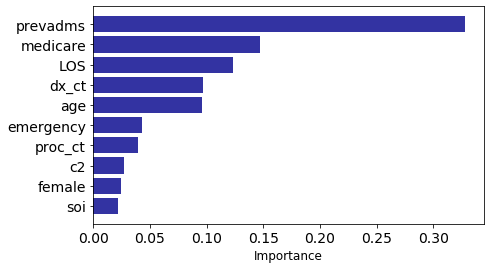

In [39]:

feature_imports = clf.feature_importances_
most_imp_features = pd.DataFrame([f for f in zip(features, feature_imports)],
                                 columns=["Feature", "Importance"]).nlargest(10, "Importance")

most_imp_features.sort_values(by="Importance", inplace=True)
plt.figure(figsize=(7, 4))
plt.rc('xtick',labelsize=14)
plt.barh(range(len(most_imp_features)), most_imp_features.Importance, align='center', alpha=0.8, color='darkblue')
plt.yticks(range(len(most_imp_features)), most_imp_features.Feature, fontsize=14)
plt.xlabel('Importance', fontsize=12)
#plt.title("Most Important Features", fontsize=14)
# plt.show()

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;From the results of making predictions from the testing data, confusion matrices were created. Confusion matrices have an x-axis of actual values and a y-axis of predicted values. The results of testing the data produce values that fall into one of four categories: true positives, false positives, true negatives, and false negatives. If a classification model is of good quality, there will be a large number of true positives and a large number of true negatives. Within the two by two confusion matrix, the largest values would ideally appear in the upper left and lower right cells. 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The values in the confusion matrices are proportionate to the testing subsample of the dataset, which consisted of N/K records, in this case, 19658 records. The confusion matrices created have large values in the upper left cells, indicating that the decision tree models produced true positives with high accuracy. This represents that non-readmission hospital stays are identified as non-readmission hospital stays accurately. However, very low number of true negatives were predicted. True negatives represent accurate identification of hospital stays which led to readmission. The value presented is very low and suggest an inability for the model to predict readmission within the test dataset. 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The classification report goes on to identify precision, recall, f1-score and support for each of the two classes. As expected based on the outcome of the confusion matrix, these measures are all given high values for the non-target class, and low values for the target class. 


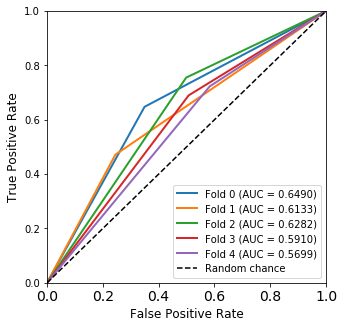

In [38]:
fig = plt.figure(figsize=(5,5))

for i in range(len(rocs)):
    fpr, tpr, thresholds = rocs[i]
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label='Fold %d (AUC = %0.4f)' % (i, roc_auc))

#plt.title('Receiver Operating Characteristic', size = 18)
#plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)

plt.plot([0, 1], [0, 1],'k--', label='Random chance')

plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate', size=12)
plt.xlabel('False Positive Rate', size =12)
plt.show()

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The AUC-ROC curve is a standard performance measure which summarizes the above points. The ROC (Receiver Operating Characteristics) curve is a cumulative distribution curve of the true positive rates versus false positive rates. The AUC value is the Area Under the Curve of the ROC curve. The AUC value is 0.527, which is nearly the lowest possible value of 0.5. An AUC value of 0.5 means that the model has very little ability to discriminate between the target variables. The ROC curve for a well-sorted model should arc away from the dotted red line, leading to a higher value for AUC.

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.2. Visualize Results with GraphViz

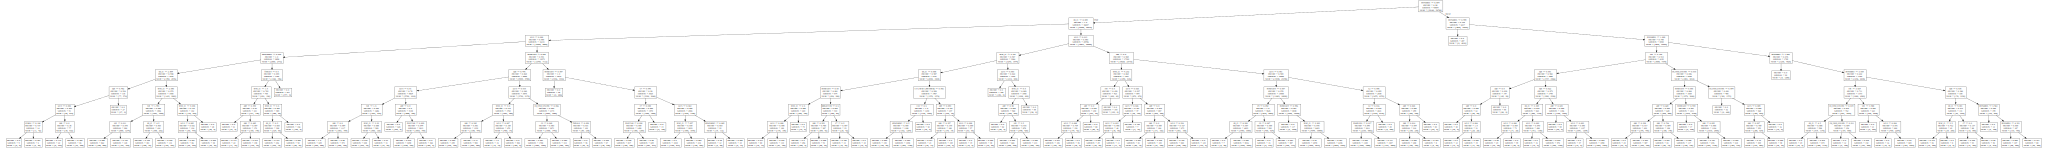

In [15]:
from sklearn.tree import export_graphviz
from IPython.display import SVG
from graphviz import Source

export_graphviz(clf) 
graph = Source(export_graphviz(clf, out_file=None, feature_names=features))
SVG(graph.pipe(format='svg'))

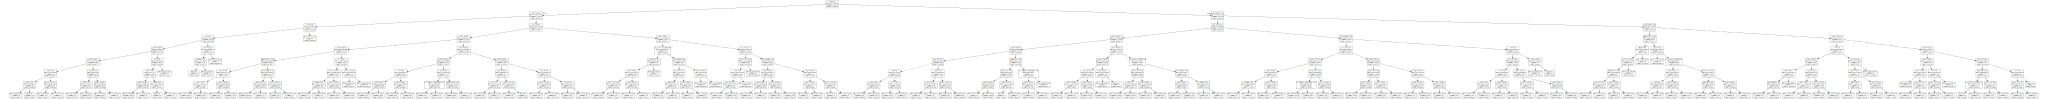

In [91]:
from sklearn.tree import export_graphviz
from IPython.display import SVG
from graphviz import Source

export_graphviz(reg) 
graph = Source(export_graphviz(reg, out_file=None, feature_names=features))
SVG(graph.pipe(format='svg'))

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The graphviz tree shows the decision nodes at each layer of the tree. The most important feature in the model was age, and the model split the dataset on age at ~20 years old and less and ~20 years and above. It is interesting that the model so clearly differentiates between pediatric and adult populations without prompting. Within the dataset and the hospital environment, it may suggest that there are fundamental differences in the ways that minors and adults are treated, which would not be a surprising finding. Age as a feature is seen several more times in the tree, spliting the subset of minors at low levels, 0.002 years, effectively separating newborns from pediatric patients. A slightly higher decision node using age is also seen in more than one place on the curve, approximately 0.1, suggesting a different readmission risk category for newborns who do not leave the hospital immediately after birth. 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The second most important feature seen in the graphviz decision tree is length of stay. It is found that for minors length of stay risk groups separate at greater than 2.5 days and less than 2.5 days. For adults, the hospital stay is much longer which separates risk groups: the divide taking place at 15 days. 

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.3. Visualize Results with Dtreeviz

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Dtreeviz is a “fancy tree” package that was developed based on the visualizations created in Stephanie Yee and Tony Chu’s R2D3 project (2019). The tree displays the feature name at each split as well as a histogram of the feature distribution across the two target values: No readmission within 30 days or Readmission within 30 days.  Since a decision tree uses a voting system to predict the classification at the last layer, the fancy visualization shows pie charts to display the portions of each class which predict readmission or no readmission. The size of the pie chart represents the support for that classification. 

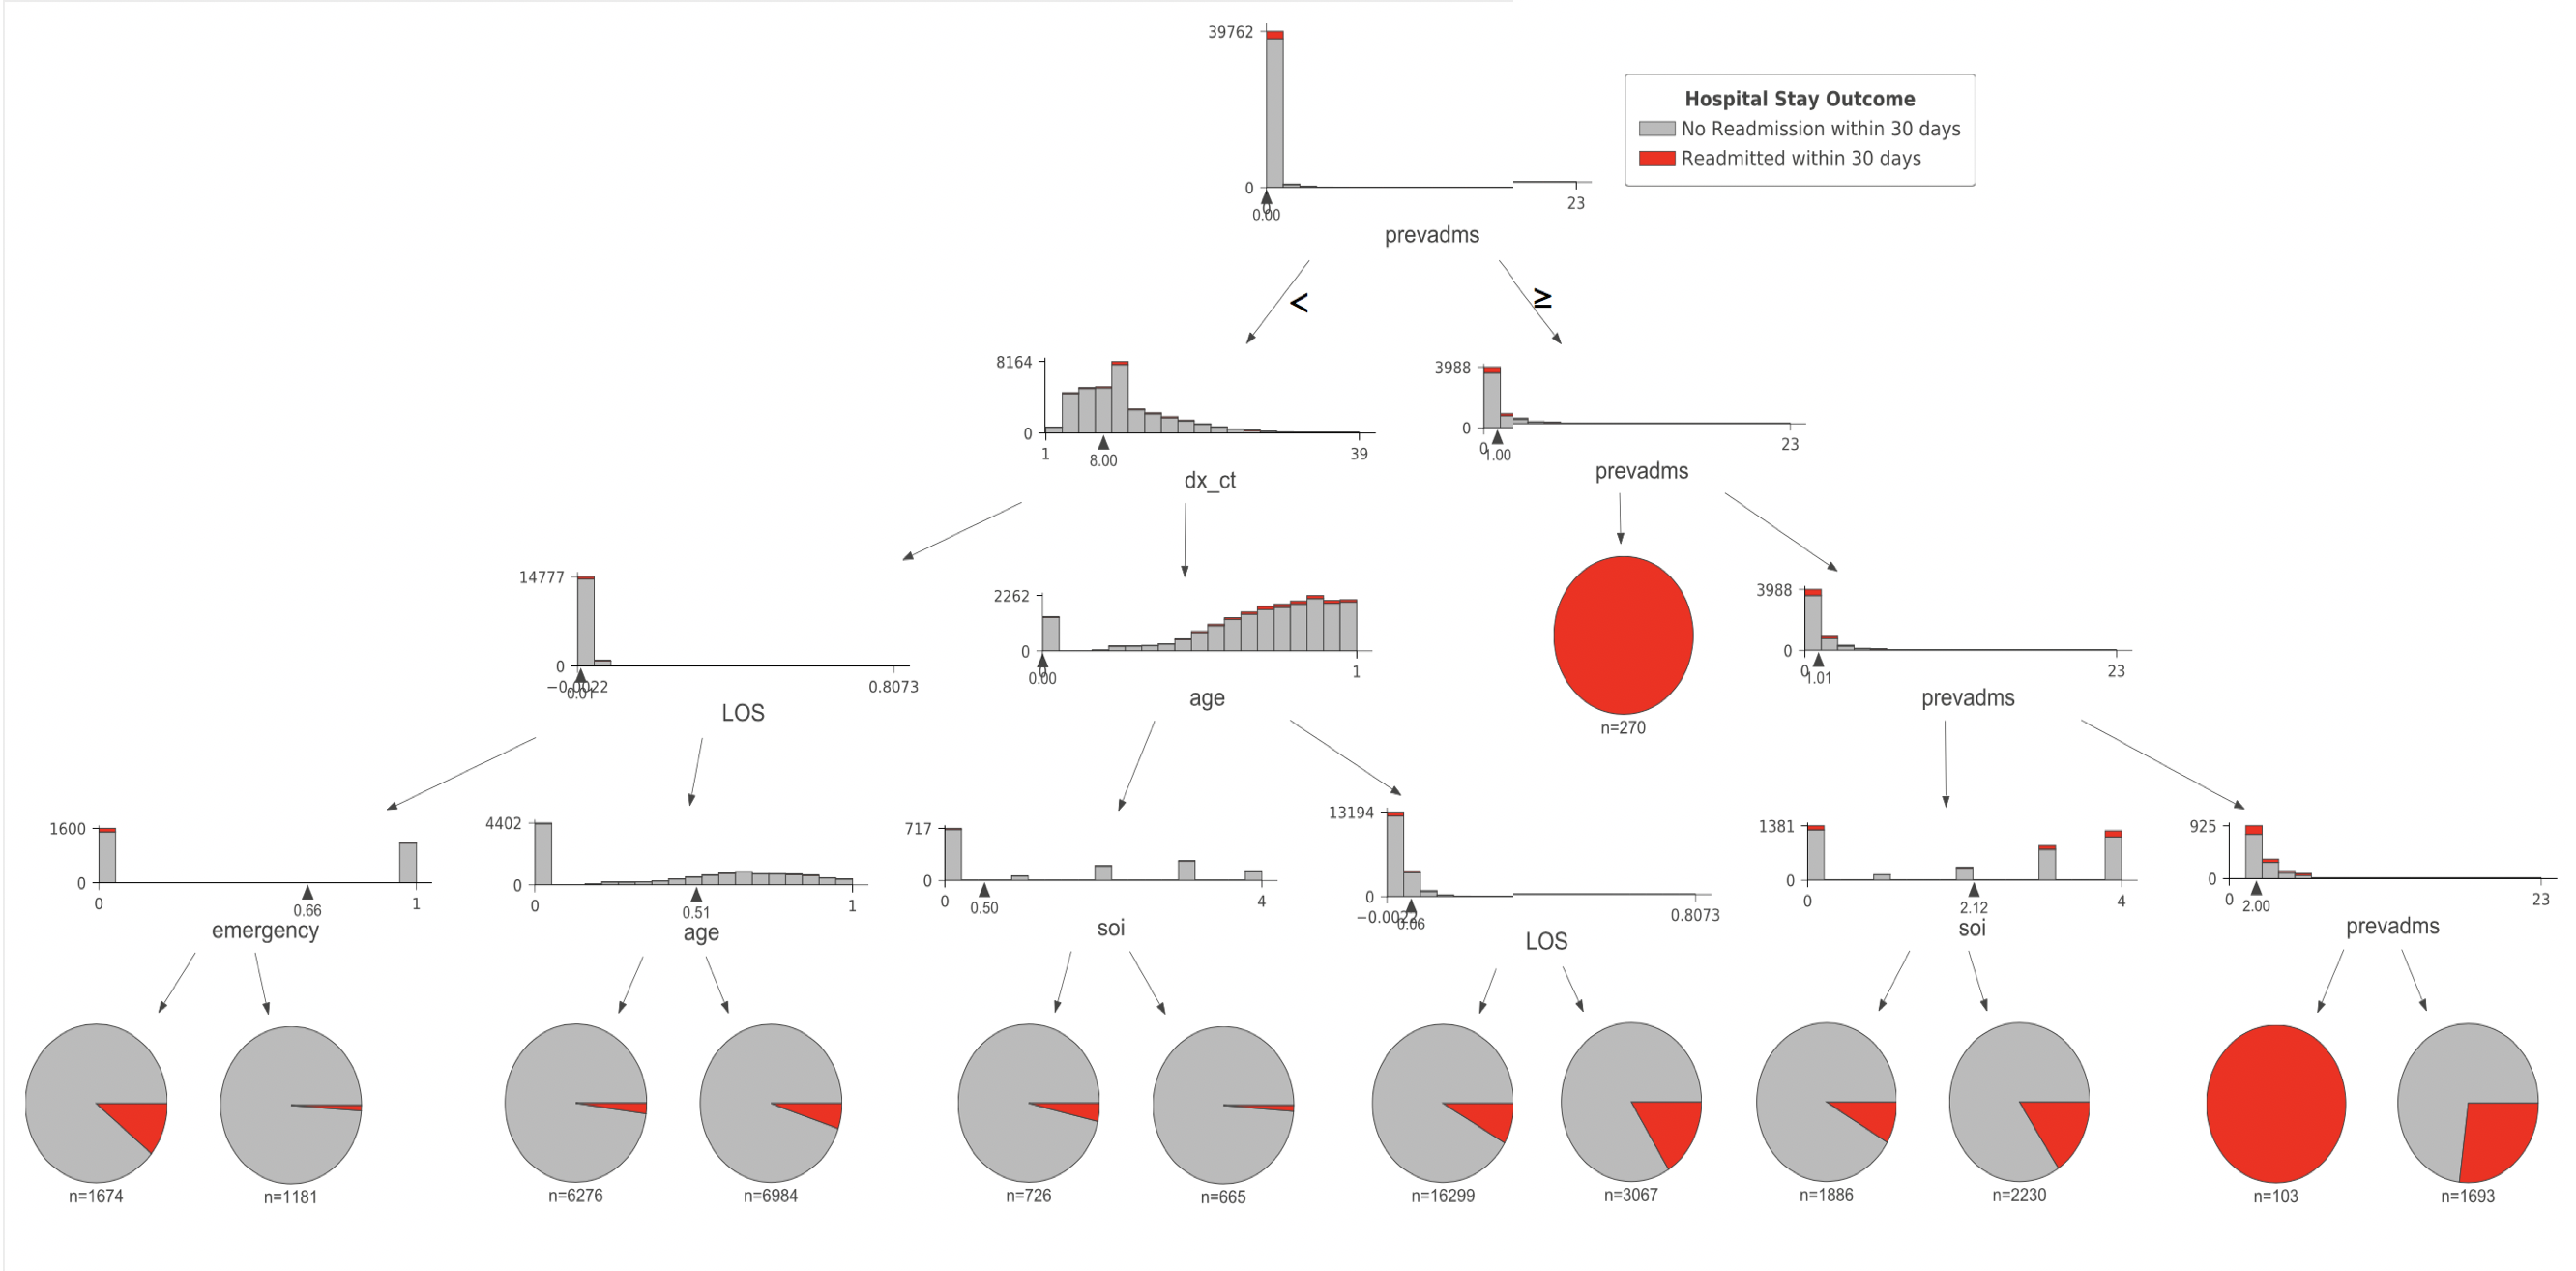

In [2]:
from IPython.display import Image
Image("dtreeviz.png")

## 4. Discussion

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The performance of this decision tree was measured by confusion matrix, statistical metrics, ROC curve and AUC value, and decision node analysis. Together, these results give us a wholistic understanding of the model and its significance within hospital readmission prediction for both this dataset, and the field as a whole. 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The confusion matrices showed a high true positive rate and a low true negative rate. The low true negative rate represents hospital stays which led to readmission which were accurately identified. This finding suggests that the model is unable to detect hospital stays which are likely to lead to readmission. Conversely, the number of true positive predictions was very high, so a large number of nonreadmission records were accurately identified. The records in the upper right hand cell of the confusion matrices represent Type I error, or false positive results, in which a hospital stay was predicted to not lead do readmission but it actually did. This scenario is particularly troublesome because it means that a patient was at risk but the model did not identify them as needing additional support. Worse, the model explicitly suggests that the patient/admission in question was safe. However, in comparing to the actual results, it is found this is not the case. Type II error is represented in the lower left hand cell of the confusion matrix. In most cases it is thought that Type II error which carries the risk previously stated as risk associated with Type I error. The difference lies within the construction of the target variable. For this research the Type II error represented records which were classified as expecting to lead to readmission, but in fact did not. Though this statistic may be concerning, the end result is that patients will be better taken care of and extra caution put in place. The hospital resources may be wasted on a case which fell into this category. 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Looking at the statistical metrics, the model had high accuracy overall and particularly high accuracy for identifying nonreadmission records. However because 94% of the MIMIC-III dataset was non-readmission, the model had the possibility of deciding 'No readmission' every time and still have an accuracy value of 94%. About 6% of the entire dataset comprised of readmission preceding encounters. Of these, the model is able to identify between 8 and 11%, with a support of only 1000 records. The macro average precision and recall values for each iteration hover around 50%, which suggests that keeping to the stratified proportions within the dataset, the model had a 50/50 chance of accurately classifying the record.  

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;For all three iterations of the model it is found that the most important features are length of stay and age. These values have practical importance to real-world readmission events as they relate to health risk and intensity of care. Therefore it is appropriate that these features have the highest ranking importance. The features ranking 3-5 are interchangable across the three models, which suggest that their importance is effectively equal, and the particular order of the important features at these levels is due to random chance. 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The AUC-ROC performance measure of 0.52 near equal to the performance of decisions made at random. This performance measure is the most useful when comparing the model to other machine learning models, using different algorithms. The unifying feature of this measure is such that an equal comparison can take place, which considers both the Type I and Type II errors. In the field, it is very rare for a model to perform at a AUC value above 0.70. While in context of the highest performing models in the field, this decision tree is not choice, there is a broader picture of the industry-wide implementation of readmission predictors. Models with a 0.70 AUC value have the impact of higher true positive rate than false positive rate. However ideally the true positive rate approaches 1. In other medical applications, an AUC of 0.95 or higher is expected in order to avoid the ramifications of type II error leading to poor outcomes for patients. 



## 5. Conclusion

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Since 2012 hundreds of machine learning models have attempted to predict horpital readmission, but the academic community has not seen a significant change in the model performances over the years. This is indicative of a highly complex system including factors which are not recorded in EHRs. For example, the inclusion of aftercare data, and the transition to care by primary care physicians is not available. Additionally, the time and frequency of observation period as opposed to admission is an important factor. In a few short years following ACA, the readmission rates dropped significantly, which is thought to be a change in the administrative classification of many hospital stays. One group suggests that these administrative changes has actually had a detrimental effect on patient outcomes. Another might question the degree of preventability of hospital readmissions to begin with, as many are planned and/or unavoiable. 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;At the same time, the healthcare industry is flooded with new technologies that boast the benefits of using machine learning within the hospital setting. In light of the change and to stay competitive, hospitals have little choice but to invest. However it is unlikely at this juncture that any machine learning tools will be of benefit directly to either patients or physicians. The implementation of machine learning information technology infrastructure is pushed by marketing and sales departments, rather than medical benefit.

## References

1. Donzé, J., Aujesky, D., Williams, D., & Schnipper, J. L. (2013). Potentially Avoidable 30-Day Hospital Readmissions in Medical Patients: Derivation and Validation of a Prediction Model. JAMA Internal Medicine, 173(8), 632–638. https://doi.org/10.1001/jamainternmed.2013.3023
2. Gupta, A., Allen, L. A., Bhatt, D. L., Cox, M., DeVore, A. D., Heidenreich, P. A., … Fonarow, G. C. (2018). Association of the Hospital Readmissions Reduction Program Implementation With Readmission and Mortality Outcomes in Heart Failure. JAMA Cardiology, 3(1), 44–53. https://doi.org/10.1001/jamacardio.2017.4265
3. Lou, Y., Caruana, R., & Gehrke, J. (2012). Intelligible models for classification and regression. Proceedings of the 18th ACM SIGKDD International Conference on Knowledge Discovery and Data Mining - KDD ’12, 150. https://doi.org/10.1145/2339530.2339556
4. MHA_SDS_Readmits_Technical_01122016.pdf. (n.d.). Retrieved from http://focusonhospitals.com/wp-content/uploads/2016/02/MHA_SDS_Readmits_Technical_01122016.pdf
Hospital Readmissions Reduction Program (HRRP) | CMS. (n.d.). Retrieved November 16, 2019, from https://www.cms.gov/Medicare/Medicare-Fee-for-Service-Payment/AcuteInpatientPPS/Readmissions-Reduction-Program
5. Introduction | Meaningful Use | CDC. (2019, September 10). Retrieved November 16, 2019, from https://www.cdc.gov/ehrmeaningfuluse/introduction.html
6. Artetxe, A., Beristain, A., & Graña, M. (2018). Predictive models for hospital readmission risk: A 
systematic review of methods. Computer Methods and Programs in Biomedicine, 164, 49–64. https://doi.org/10.1016/j.cmpb.2018.06.006
7. Chandra, A., Rahman, P. A., Sneve, A., McCoy, R. G., Thorsteinsdottir, B., Chaudhry, R., … 
8. Takahashi, P. Y. (2019). Risk of 30-day hospital readmission among patients 
discharged to skilled nursing facilities: Development and validation of a risk-prediction model. Journal of the American Medical Directors Association, 20(4), 444-450.e2. https://doi.org/10.1016/j.jamda.2019.01.137
9. Deschepper, M., Eeckloo, K., Vogelaers, D., & Waegeman, W. (2019). A hospital wide 
predictive model for unplanned readmission using hierarchical ICD data. Computer Methods and Programs in Biomedicine, 173, 177–183. https://doi.org/10.1016/j.cmpb.2019.02.007
10. Garmendia, A., Graña, M., Lopez-Guede, J. M., & Rios, S. (2019). Neural and statistical 
predictors for time to readmission in emergency departments: A case study. Neurocomputing, 354, 3–9. https://doi.org/10.1016/j.neucom.2018.05.135
11. Golas, S. B., Shibahara, T., Agboola, S., Otaki, H., Sato, J., Nakae, T., … Jethwani, K. (2018). A 
machine learning model to predict the risk of 30-day readmissions in patients with heart failure: A retrospective analysis of electronic medical records data. BMC Medical Informatics and Decision Making; London, 18. http://dx.doi.org.mutex.gmu.edu/10.1186/s12911-018-0620-z
12. Jiang, S., Chin, K.-S., Qu, G., & Tsui, K. L. (2018). An integrated machine learning framework 
for hospital readmission prediction. Knowledge-Based Systems, 146, 73–90. 
https://doi.org/10.1016/j.knosys.2018.01.027
13. Mahajan, S. M., Mahajan, A. S., King, R., & Negahban, S. (2018). Predicting risk of 30-day 
readmissions using two emerging machine learning methods. Studies In Health Technology And Informatics, 250, 250–255. (29857454).
14. Wolff, P., Graña, M., Ríos, S. A., & Yarza, M. B. (2019a). Machine learning readmission risk 
modeling: A pediatric case study. BioMed Research International; New York, 2019. 
http://dx.doi.org.mutex.gmu.edu/10.1155/2019/8532892
15. Xiao, C., Ma, T., Dieng, A. B., Blei, D. M., & Wang, F. (2018). Readmission prediction via deep 
contextual embedding of clinical concepts. 13(4), 1–15.  https://doi.org/10.7916/D82V3ZBG
16. Xue, Y., Liang, H., Norbury, J., Gillis, R., & Killingworth, B. (2018). Predicting the risk of acute 
care readmissions among rehabilitation inpatients: A machine learning approach. Journal of Biomedical Informatics, 86, 143–148. https://doi.org/10.1016/j.jbi.2018.09.009
17. MIMIC-III, a freely accessible critical care database. Johnson AEW, Pollard TJ, Shen L, Lehman L, Feng M, Ghassemi M, Moody B, Szolovits P, Celi LA, and Mark RG. Scientific Data (2016). DOI: 10.1038/sdata.2016.35. Available from: http://www.nature.com/articles/sdata201635
